In [1]:
import os
import torch
import torchaudio
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
DATASET_PATH = os.path.join('morse_dataset', 'morse_dataset')
PREPROCESS = False
TRAIN = False

In [3]:
from utils import normalize_nonzero, extract_morse

waveform, sample_rate = torchaudio.load(os.path.join(DATASET_PATH, '1234.opus'))
transform = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, n_mels=64)
mel_spec = transform(waveform)    
mel_spec = extract_morse(mel_spec)
mel_spec = normalize_nonzero(mel_spec)

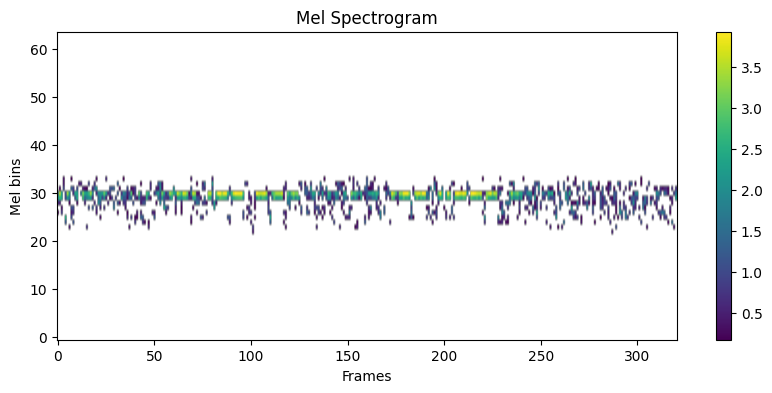

In [4]:
plt.figure(figsize=(10, 4))
plt.imshow(mel_spec.log2()[0,:,:].numpy(), aspect='auto', origin='lower')
plt.title('Mel Spectrogram')
plt.xlabel('Frames')
plt.ylabel('Mel bins')
plt.colorbar()
plt.show()

In [5]:
import torchaudio.transforms as T
from normalize import Normalize
from extract_morse import ExtractMorse

def build_transform(sample_rate=8000, n_mels=64):
    return torch.nn.Sequential(
        T.Resample(orig_freq=sample_rate, new_freq=8000),
        T.MelSpectrogram(sample_rate=8000, n_mels=n_mels),
        T.AmplitudeToDB(),
        ExtractMorse(),
        Normalize()
    )

In [6]:
from preprocessing import preprocess_dataset

df = pd.read_csv('train.csv')
transform = build_transform()
labels_dict = {
        f"{row['id']}": row['message']
        for _, row in df.iterrows()
    }

if PREPROCESS:
    preprocess_dataset(DATASET_PATH, "data_preprocessed", labels_dict, transform)

In [7]:
from preprocessed_dataset import PreprocessedDataset
from utils import build_vocab

char2idx, idx2char = build_vocab(df['message'])

train_dataset = PreprocessedDataset('data_preprocessed/train', char2idx)
val_dataset = PreprocessedDataset('data_preprocessed/val', char2idx)

In [8]:
import torch
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    features, targets, input_lengths, target_lengths = zip(*batch)

    features = [f.transpose(0, 1) for f in features]

    padded_features = pad_sequence(features, batch_first=True)
    padded_targets = torch.cat(targets)

    input_lengths = torch.tensor([f.shape[0] for f in features], dtype=torch.long)
    target_lengths = torch.tensor(target_lengths, dtype=torch.long)

    return padded_features, padded_targets, input_lengths, target_lengths

In [9]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,
    batch_size=256,
    shuffle=True,
    collate_fn=collate_fn,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=256,
    shuffle=True,
    collate_fn=collate_fn,
)

In [10]:
from morse_ctc_model import MorseCTCModel
from train import train

model = MorseCTCModel(
    input_dim=64,
    hidden_dim=128,
    output_dim=len(train_dataset.char2idx) + 1
).to('cuda')

if TRAIN:
    train(model=model, train_loader=train_loader, val_loader=val_loader)
else:
    model.load_state_dict(torch.load('models/best_model.pt', map_location='cuda'))

In [11]:
from preprocessing import preprocess_audio
from utils import greedy_decode
import os
import torch
import torchaudio
import pandas as pd
from torch.nn.functional import log_softmax

model.eval()
submission = []

audio_dir = DATASET_PATH
target_files = sorted([
    f for f in os.listdir(audio_dir)
    if f.endswith('.opus') and 30001 <= int(os.path.splitext(f)[0]) <= 35000
], key=lambda x: int(os.path.splitext(x)[0]))

with torch.no_grad():
    for fname in target_files:
        path = os.path.join(audio_dir, fname)
        mel = preprocess_audio(path, transform)
        mel = mel.transpose(0, 1).unsqueeze(0).to('cuda')
        input_len = torch.tensor([mel.shape[1]], device='cuda')

        logits = model(mel)                                 # [T, 1, C]
        log_probs = log_softmax(logits, dim=-1)

        decoded = greedy_decode(log_probs, input_len, idx2char)
        submission.append({
            "id": fname,
            "message": decoded[0]
        })

df = pd.DataFrame(submission)
df.to_csv("submission.csv", index=False)

In [12]:
from torch.nn.functional import log_softmax
from torch.nn import CTCLoss
import editdistance

model.eval()
ctc_loss_fn = CTCLoss(blank=0, zero_infinity=True)
val_losses = []
levenshtein_scores = []

with torch.no_grad():
    for features, targets, input_lengths, target_lengths in val_loader:
        features = features.to('cuda')
        targets = targets.to('cuda')
        input_lengths = input_lengths.to('cuda')
        target_lengths = target_lengths.to('cuda')

        log_probs = model(features)
        log_probs = log_softmax(log_probs, dim=-1)

        loss = ctc_loss_fn(log_probs, targets, input_lengths, target_lengths)
        val_losses.append(loss.item())

        log_probs_btc = log_probs.transpose(0, 1)
        decoded_batch = greedy_decode(log_probs, input_lengths, idx2char)

        target_batch = []
        start = 0
        for length in target_lengths:
            length = int(length)
            target_seq = targets[start:start + length]
            text = ''.join([idx2char[int(c)] for c in target_seq])
            target_batch.append(text)
            start += length

        for pred, true in zip(decoded_batch, target_batch):
            dist = editdistance.eval(pred, true)
            levenshtein_scores.append(dist)

mean_val_loss = sum(val_losses) / len(val_losses)
mean_levenshtein = sum(levenshtein_scores) / len(levenshtein_scores)

print(f"Val CTC Loss: {mean_val_loss:.4f}")
print(f"Mean Levenshtein: {mean_levenshtein:.4f}")

Val CTC Loss: 0.3067
Mean Levenshtein: 0.6560
